# Import

In [1]:
import numpy as np
import pandas as pd
import random
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from utils import manage_outlier

from sklearn.metrics import mean_absolute_error as mae
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

from lightgbm import LGBMRegressor as lgbm
from xgboost import XGBRegressor as xgb
from catboost import CatBoostRegressor as cat
from sklego.linear_model import LADRegression as lad

plt.rc('font', family='Malgun Gothic')

import warnings
warnings.filterwarnings('ignore')

In [2]:
# seed 고정
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42)

# Load Data

In [3]:
train = pd.read_csv('./open/train.csv').drop('ID',axis=1)
test = pd.read_csv('./open/test.csv').drop('ID',axis=1)
submission = pd.read_csv('./open/sample_submission.csv')

In [4]:
# 연료 특징들을 하나의 컬럼으로 통합
train['연료'] = 0
for col in tqdm(['압축천연가스(CNG)','경유','가솔린','하이브리드','액화석유가스(LPG)']):
    train.loc[train[col]==1,'연료'] = col
train = train.drop(['압축천연가스(CNG)','경유','가솔린','하이브리드','액화석유가스(LPG)'],axis=1)

test['연료'] = 0
for col in tqdm(['압축천연가스(CNG)','경유','가솔린','하이브리드','액화석유가스(LPG)']):
    test.loc[test[col]==1,'연료'] = col
test = test.drop(['압축천연가스(CNG)','경유','가솔린','하이브리드','액화석유가스(LPG)'],axis=1)

100%|██████████| 5/5 [00:00<00:00, 1662.43it/s]


# Preprocessing & Feature Engineering

## 1. Preprocessing(1)

#### 이상치 제거
- 생산년도, 주행거리 -> 극단 이상치 제거
- 모델출시년도 -> IQR Capping
- 배기량 -> 이상치 제거

In [5]:
print('이상치 제거 전 train data 개수 : ', len(train))

이상치 제거 전 train data 개수 :  57920


In [6]:
manage_outlier(train, '생산년도', how='delete', target='extreme')
manage_outlier(train, '모델출시년도', how='capping', target='normal')
manage_outlier(train, '주행거리', how='delete', target='extreme')
manage_outlier(train, '배기량', how='delete', target='normal')

In [7]:
print('이상치 제거 후 train data 개수 : ', len(train))

이상치 제거 후 train data 개수 :  54376


## 2. Feature Engineering(1)

In [8]:
# 배기량을 기준으로 차량 구분 컬럼 추가
lst = []
for val in tqdm(train['배기량']):
    if val >= 2000:
        lst.append('대형')
    elif val >= 1600:
        lst.append('중형')
    elif val >= 1000:
        lst.append('소형')
    else:
        lst.append('경형')

train['배기량별 구분'] = lst

lst = []
for val in tqdm(test['배기량']):
    if val >= 2000:
        lst.append('대형')
    elif val >= 1600:
        lst.append('중형')
    elif val >= 1000:
        lst.append('소형')
    else:
        lst.append('경형')

test['배기량별 구분'] = lst

# 배기량, 구분을 기준으로 자동차세 컬럼 추가
train['연간 자동차세'] = 0
train.loc[train['배기량별 구분']=='경형','연간 자동차세'] = train['배기량'] * 90
train.loc[train['배기량별 구분']=='소형','연간 자동차세'] = train['배기량'] * 140
train.loc[np.logical_or(train['배기량별 구분']=='중형', train['배기량별 구분']=='대형'),'연간 자동차세'] = train['배기량'] * 220

test['연간 자동차세'] = 0
test.loc[test['배기량별 구분']=='경형','연간 자동차세'] = test['배기량'] * 90
test.loc[test['배기량별 구분']=='소형','연간 자동차세'] = test['배기량'] * 140
test.loc[np.logical_or(test['배기량별 구분']=='중형', test['배기량별 구분']=='대형'),'연간 자동차세'] = test['배기량'] * 220

train['지방교육세'] = train['연간 자동차세'] * .3
test['지방교육세'] = test['연간 자동차세'] * .3

train['총 자동차세'] = train['연간 자동차세'] + train['지방교육세']
test['총 자동차세'] = test['연간 자동차세'] + test['지방교육세']

# 생산년도, 출시년도를 기준으로 컬럼 추가 및 자동차세 할인 적용
train['생산이후'] = 2023 - train['생산년도']
train['모델출시이후'] = 2023 - train['모델출시년도']

test['생산이후'] = 2023 - test['생산년도']
test['모델출시이후'] = 2023 - test['모델출시년도']

train['자동차세 할인 여부'] = 0
train.loc[train['생산이후']>=3,'자동차세 할인 여부'] = 1

test['자동차세 할인 여부'] = 0
test.loc[test['생산이후']>=3,'자동차세 할인 여부'] = 1

train['할인 후 자동차세'] = 0
train.loc[train['생산이후']>=3,'할인 후 자동차세'] = (train['연간 자동차세'] + train['지방교육세'])*(1 - (train['생산이후']-2)*.05)
train.loc[train['생산이후']>=13,'할인 후 자동차세'] = (train['연간 자동차세'] + train['지방교육세'])*.5

test['할인 후 자동차세'] = 0
test.loc[test['생산이후']>=3,'할인 후 자동차세'] = (test['연간 자동차세'] + test['지방교육세'])*(1 - (test['생산이후']-2)*.05)
test.loc[test['생산이후']>=13,'할인 후 자동차세'] = (test['연간 자동차세'] + test['지방교육세'])*.5

# 생산 이후, 주행거리를 기준으로 일반, 엔진 보증 컬럼 추가
train['일반보증'] = 0
train.loc[np.logical_or(train['생산이후']<=3, train['주행거리']<=60000),'일반보증'] = 1

test['일반보증'] = 0
test.loc[np.logical_or(test['생산이후']<=3, test['주행거리']<=60000),'일반보증'] = 1

train['엔진보증'] = 0
train.loc[np.logical_or(train['생산이후']<=5, train['주행거리']<=100000),'엔진보증'] = 1

test['엔진보증'] = 0
test.loc[np.logical_or(test['생산이후']<=5, test['주행거리']<=100000),'엔진보증'] = 1

# 주행거리별 구분 추가
train['주행거리별 구분'] = 0
train.loc[np.logical_and(train['주행거리']>=0, train['주행거리']<=50000),'주행거리별 구분'] = '양호'
train.loc[np.logical_and(train['주행거리']>50000, train['주행거리']<=100000),'주행거리별 구분'] = '좀많음'
train.loc[np.logical_and(train['주행거리']>100000, train['주행거리']<=200000),'주행거리별 구분'] = '많음'
train.loc[train['주행거리']>200000,'주행거리별 구분'] = '아주많음'

test['주행거리별 구분'] = 0
test.loc[np.logical_and(test['주행거리']>=0, test['주행거리']<=50000),'주행거리별 구분'] = '양호'
test.loc[np.logical_and(test['주행거리']>50000, test['주행거리']<=100000),'주행거리별 구분'] = '좀많음'
test.loc[np.logical_and(test['주행거리']>100000, test['주행거리']<=200000),'주행거리별 구분'] = '많음'
test.loc[test['주행거리']>200000,'주행거리별 구분'] = '아주많음'

# 판매구역 중 특이한 분포를 보이는 MOR 구역 구분 추가
train['Is_MOR'] = 0
train.loc[train['판매구역']=='MOR', 'Is_MOR'] = 1
test['Is_MOR'] = 0
test.loc[test['판매구역']=='MOR', 'Is_MOR'] = 1

100%|██████████| 14480/14480 [00:00<00:00, 4797276.61it/s]

## 3. Preprocessing(2)

### 인코딩
- 범주형 변수들의 값을 가격을 기준으로 랭크 인코딩

#### 교유값 확인

In [9]:
ordinal_features = ['브랜드', '차량모델명', '판매도시', '판매구역', '연료', '배기량별 구분',
                    '자동차세 할인 여부', '일반보증', '엔진보증', '주행거리별 구분', 'Is_MOR']

for feature in ordinal_features:
    train_lst = np.unique(train[feature])
    test_lst = np.unique(test[feature])
    count = 0
    for label in test_lst:
        if label not in train_lst:
            count+=1
    print(f'{feature} - {count}/{len(test_lst)}')

브랜드 - 0/20
차량모델명 - 8/141
판매도시 - 320/1774
판매구역 - 0/17
연료 - 0/5
배기량별 구분 - 0/4
자동차세 할인 여부 - 0/2
일반보증 - 0/2
엔진보증 - 0/2
주행거리별 구분 - 0/4
Is_MOR - 0/2


#### 고유값 별 평균 가격을 기준으로 랭크인코딩

In [10]:
# 브랜드, 차량모델명, 판매도시 별 가격을 기준으로 랭크 인코딩
brand_idx = train[['브랜드','가격']].groupby(['브랜드']).mean().sort_values('가격').index
dict_brand = {}
for i in range(len(brand_idx)):
    key = brand_idx[i]
    value = i + 1
    dict_brand[key] = value

train['브랜드'] = train['브랜드'].map(dict_brand)
test['브랜드'] = test['브랜드'].map(dict_brand)

model_idx = train[['차량모델명','가격']].groupby(['차량모델명']).mean().sort_values('가격').index
dict_model = {}
for i in range(len(model_idx)):
    key = model_idx[i]
    value = i + 1
    dict_model[key] = value

train['차량모델명'] = train['차량모델명'].map(dict_model)
test['차량모델명'] = test['차량모델명'].map(dict_model)

city_idx = train[['판매도시','가격']].groupby(['판매도시']).mean().sort_values('가격').index
dict_city = {}
for i in range(len(city_idx)):
    key = city_idx[i]
    value = i + 1
    dict_city[key] = value

train['판매도시'] = train['판매도시'].map(dict_city)
test['판매도시'] = test['판매도시'].map(dict_city)

sector_idx = train[['판매구역','가격']].groupby(['판매구역']).mean().sort_values('가격').index
dict_sector = {}
for i in range(len(sector_idx)):
    key = sector_idx[i]
    value = i + 1
    dict_sector[key] = value

train['판매구역'] = train['판매구역'].map(dict_sector)
test['판매구역'] = test['판매구역'].map(dict_sector)

fuel_idx = train[['연료','가격']].groupby(['연료']).mean().sort_values('가격').index
dict_fuel = {}
for i in range(len(fuel_idx)):
    key = fuel_idx[i]
    value = i + 1
    dict_fuel[key] = value

train['연료'] = train['연료'].map(dict_fuel)
test['연료'] = test['연료'].map(dict_fuel)

length_idx = train[['주행거리별 구분','가격']].groupby(['주행거리별 구분']).mean().sort_values('가격').index
dict_length = {}
for i in range(len(length_idx)):
    key = length_idx[i]
    value = i + 1
    dict_length[key] = value

train['주행거리별 구분'] = train['주행거리별 구분'].map(dict_length)
test['주행거리별 구분'] = test['주행거리별 구분'].map(dict_length)

cc_idx = train[['배기량별 구분','가격']].groupby(['배기량별 구분']).mean().sort_values('가격').index
dict_cc = {}
for i in range(len(cc_idx)):
    key = cc_idx[i]
    value = i + 1
    dict_cc[key] = value

train['배기량별 구분'] = train['배기량별 구분'].map(dict_cc)
test['배기량별 구분'] = test['배기량별 구분'].map(dict_cc)

#### 결측치 처리
- train 데이터와 고유값이 상이한 test 데이터(Na) 값 0으로 처리

In [11]:
# 처리 이전 결측치의 개수
test[['차량모델명','판매도시']].isna().sum()

차량모델명     91
판매도시     345
dtype: int64

In [12]:
test.fillna(0, inplace=True)

In [13]:
# 처리 후 결측치 존재 여부 확인
test[['차량모델명','판매도시']].isna().sum()

차량모델명    0
판매도시     0
dtype: int64

## 4. Feature Engineering(2)

In [14]:
# 브랜드와 차량모델명을 감안한 브랜드파워 컬럼 추가
train['브랜드파워'] = train['브랜드'] * train['차량모델명']
test['브랜드파워'] = test['브랜드'] * test['차량모델명']

# 연료와 배기량을 감안한 유사 연비 컬럼 추가
train['유사 연비'] = train['연료'] * train['배기량']
test['유사 연비'] = test['연료'] * test['배기량']

## 5. Preprocessing(3)

### 차원압축
- 상관계수를 기반으로 압축시킬 특징 컬럼들을 선정하여 PCA 분석

#### 상관계수 확인

<Axes: >

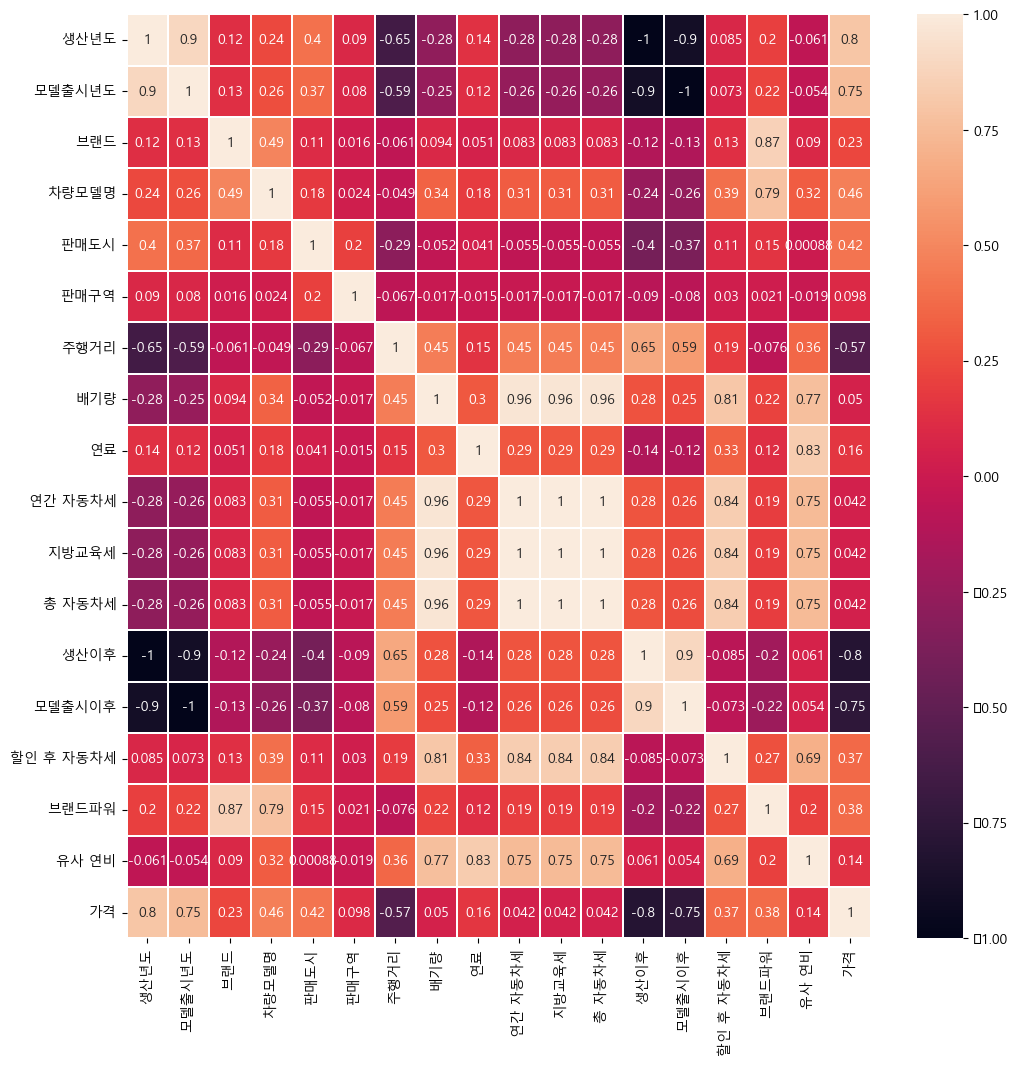

In [15]:
# 원활한 상관계수 확인을 위해 target 컬럼의 위치 이동
# train['가격'] = train.pop('가격')
plt.figure(figsize=(12,12))
sns.heatmap(train[['생산년도','모델출시년도','브랜드','차량모델명',
                   '판매도시','판매구역','주행거리','배기량','연료',
                   '연간 자동차세','지방교육세','총 자동차세','생산이후',
                   '모델출시이후','할인 후 자동차세','브랜드파워','유사 연비','가격']].corr(), annot=True, linewidths=0.1, vmax=1.0, vmin=-1.0)

#### 주성분 분석 & 차원축소
- 생산년도, 모델출시년도, 생산이후, 모델출시이후 -> 생산년도, 모델출시이후 제거
- 배기량, 연간 자동차세, 지방교육세, 총 자동차세 -> 주성분 분석 & 차원축소

In [16]:
pca = PCA(n_components=1)
pca.fit(train[['생산년도','생산이후']])
print('생산년도 압축 데이터 표현력 : ', pca.explained_variance_ratio_)
pca.fit(train[['모델출시년도','모델출시이후']])
print('모델출시년도 압축 데이터 표현력 : ', pca.explained_variance_ratio_)

생산년도 압축 데이터 표현력 :  [1.]
모델출시년도 압축 데이터 표현력 :  [1.]


In [17]:
train.drop(['생산년도','모델출시년도'],axis=1,inplace=True)
test.drop(['생산년도','모델출시년도'],axis=1,inplace=True)

In [18]:
pca = PCA(n_components=1)
pca.fit(train[['배기량','연간 자동차세','지방교육세','총 자동차세']])
print('배기량 & 자동차세 압축 데이터 표현력 : ', pca.explained_variance_ratio_)

배기량 & 자동차세 압축 데이터 표현력 :  [0.99999981]


In [19]:
train['배기량&자동차세PCA'] = pca.transform(train[['배기량','연간 자동차세','지방교육세','총 자동차세']])
train.drop(['배기량','연간 자동차세','지방교육세','총 자동차세'],axis=1,inplace=True)

test['배기량&자동차세PCA'] = pca.transform(test[['배기량','연간 자동차세','지방교육세','총 자동차세']])
test.drop(['배기량','연간 자동차세','지방교육세','총 자동차세'],axis=1,inplace=True)

#### 축소 이후 상관계수 확인

<Axes: >

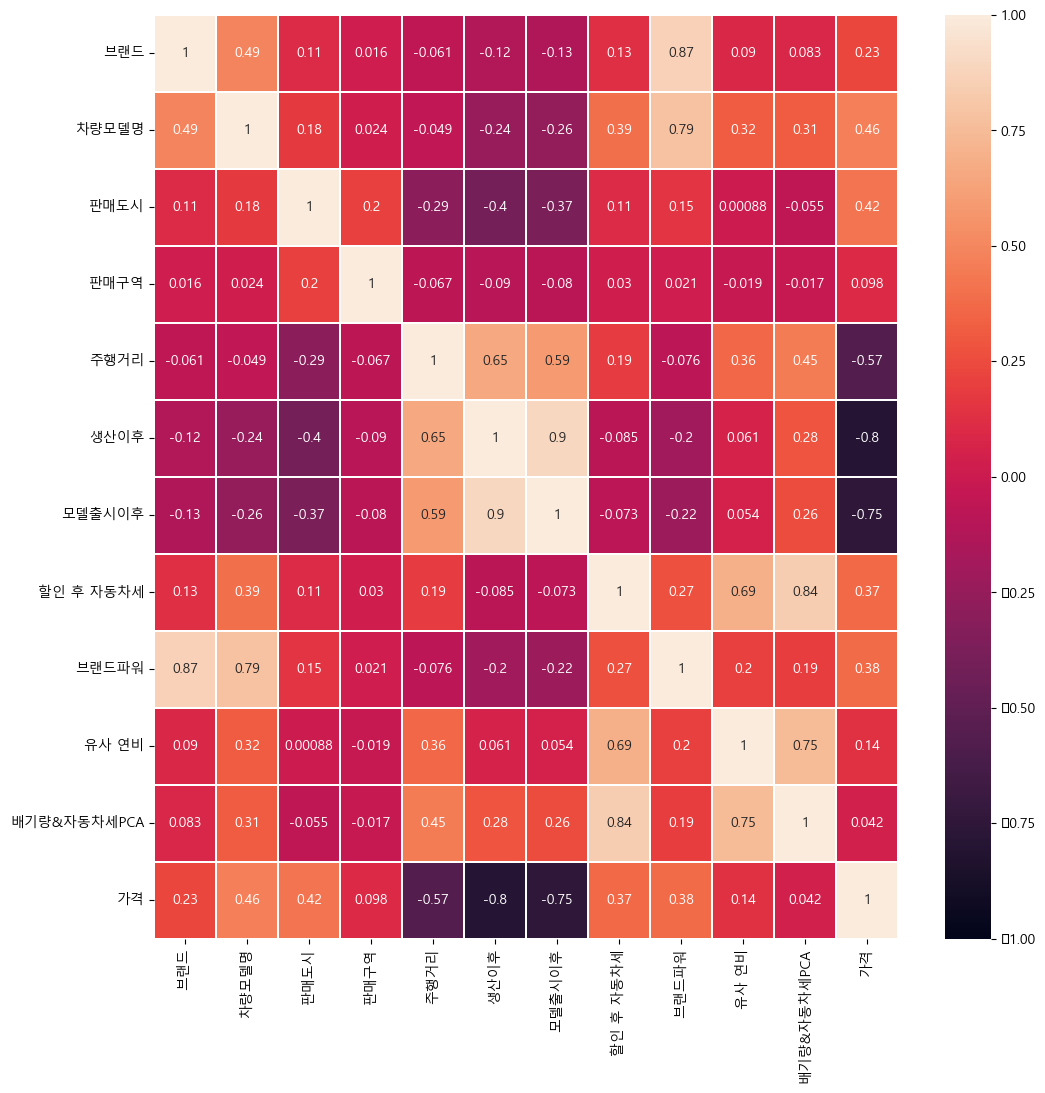

In [20]:
# 원활한 상관계수 확인을 위해 target 컬럼의 위치 이동
# train['가격'] = train.pop('가격')
plt.figure(figsize=(12,12))
sns.heatmap(train[['브랜드','차량모델명','판매도시','판매구역','주행거리','생산이후',
                   '모델출시이후','할인 후 자동차세','브랜드파워','유사 연비','배기량&자동차세PCA','가격']].corr(), annot=True, linewidths=0.1, vmax=1.0, vmin=-1.0)

### 정규화
- xdata, ydata 분리
- MinMaxScaler를 이용하여 정규화

In [21]:
train_x = train.drop('가격', axis=1)
train_y = train['가격']
test_x = test

In [22]:
scaler = MinMaxScaler()
train_x_scaled = pd.DataFrame(scaler.fit_transform(train_x), columns=train_x.columns)
test_x_scaled = pd.DataFrame(scaler.transform(test_x), columns=test_x.columns)

# Modeling

## 1. 검증 데이터 분리(1)
- train_test_split 함수 이용

In [23]:
x_train, x_val, y_train, y_val = train_test_split(train_x_scaled, train_y, test_size=.15, random_state=42)

## 2. 성능 측정

- AutoML(pycaret)

In [24]:
# AutoML은 Colab으로 하는걸로...
"""
from pycaret.utils import check_metric
from pycaret.regression import setup, compare_models, tune_model, blend_models, finalize_model, evaluate_model, predict_model

show = pd.concat([x_train, y_train], axis=1).rename(columns={'가격':'target'})
show_val = pd.concat([x_val, y_val], axis=1).rename(columns={'가격':'target'})

setup_data = setup(data=show, target='target',
                   test_data=show_val, session_id=42)

AUTO = compare_models(sort='MAE', fold=5, n_select=5)
TUNE = [tune_model(i, fold=5, optimize='MAE') for i in AUTO]
BLEND = blend_models(estimator_list=TUNE, optimize='MAE', fold=5)
FINAL = finalize_model(BLEND)
evaluate_model(FINAL, fold=5)
pred = predict_model(FINAL, data=test_x_scaled)
"""

"\nfrom pycaret.utils import check_metric\nfrom pycaret.regression import setup, compare_models, tune_model, blend_models, finalize_model, evaluate_model, predict_model\n\nshow = pd.concat([x_train, y_train], axis=1).rename(columns={'가격':'target'})\nshow_val = pd.concat([x_val, y_val], axis=1).rename(columns={'가격':'target'})\n\nsetup_data = setup(data=show, target='target',\n                   test_data=show_val, session_id=42)\n\nAUTO = compare_models(sort='MAE', fold=5, n_select=5)\nTUNE = [tune_model(i, fold=5, optimize='MAE') for i in AUTO]\nBLEND = blend_models(estimator_list=TUNE, optimize='MAE', fold=5)\nFINAL = finalize_model(BLEND)\nevaluate_model(FINAL, fold=5)\npred = predict_model(FINAL, data=test_x_scaled)\n"

- LGBM

In [24]:
LGBM = lgbm(objective='mae', metric='mae', n_estimators=20000, random_state=42,
            max_depth=11, num_leaves=255, learning_rate=.01, reg_alpha=.5, reg_lambda=.05,
            subsample=.4)
LGBM.fit(x_train, y_train, eval_set=[(x_train,y_train), (x_val, y_val)], early_stopping_rounds=1000, verbose=1000)

[1000]	training's l1: 4.58747	valid_1's l1: 5.5262
[2000]	training's l1: 4.20141	valid_1's l1: 5.44703
[3000]	training's l1: 3.99705	valid_1's l1: 5.42335
[4000]	training's l1: 3.88702	valid_1's l1: 5.41158
[5000]	training's l1: 3.79185	valid_1's l1: 5.40075
[6000]	training's l1: 3.75126	valid_1's l1: 5.39884
[7000]	training's l1: 3.70603	valid_1's l1: 5.39526
[8000]	training's l1: 3.66755	valid_1's l1: 5.39321
[9000]	training's l1: 3.61365	valid_1's l1: 5.39242
[10000]	training's l1: 3.58895	valid_1's l1: 5.39114
[11000]	training's l1: 3.56497	valid_1's l1: 5.39044
[12000]	training's l1: 3.53342	valid_1's l1: 5.39022


LGBMRegressor(learning_rate=0.01, max_depth=11, metric='mae',
              n_estimators=20000, num_leaves=255, objective='mae',
              random_state=42, reg_alpha=0.5, reg_lambda=0.05, subsample=0.4)

In [26]:
print("LGBM Validation MAE : {}".format(mae(y_val, LGBM.predict(x_val))))

LGBM Validation MAE : 5.3896153087722585


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


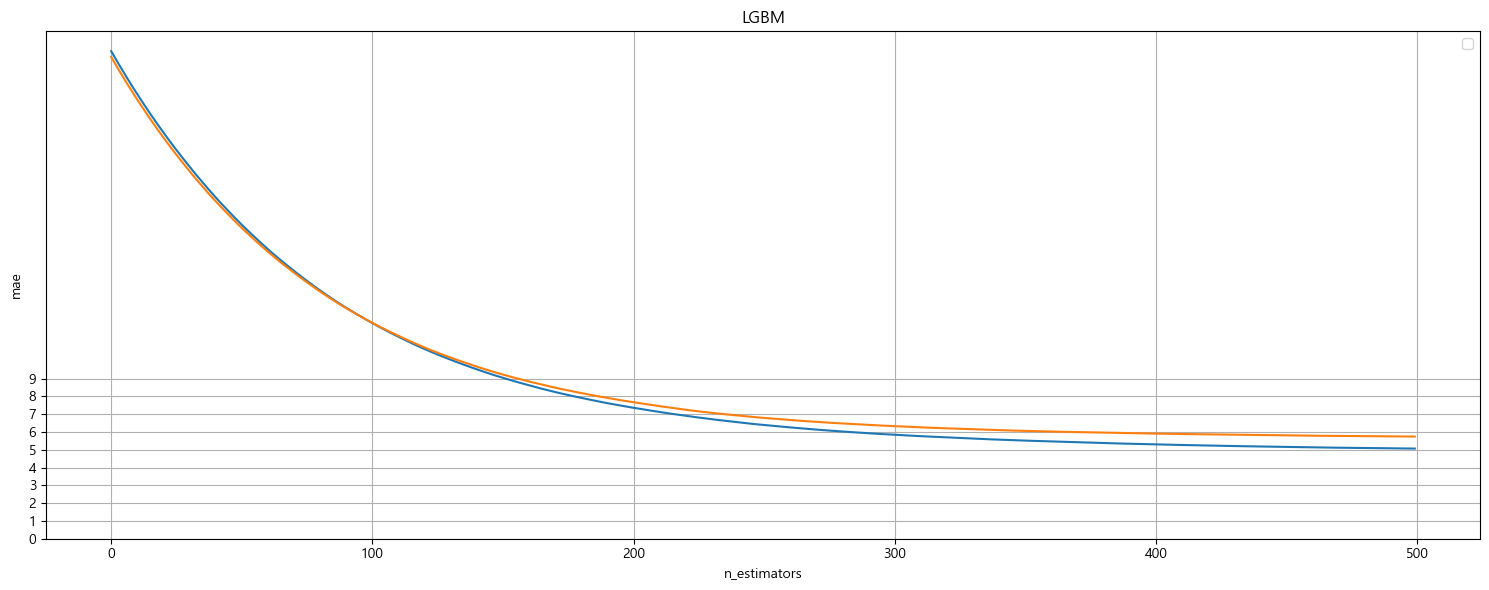

In [49]:
plt.figure(figsize=(15,6))
plt.plot(LGBM.evals_result_['training']['l1'][:500])
plt.plot(LGBM.evals_result_['valid_1']['l1'][:500])
plt.xticks(np.arange(0,501,step=100))
plt.yticks(np.arange(0,10,step=1))
plt.xlabel('n_estimators')
plt.ylabel('mae')
plt.title('LGBM')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


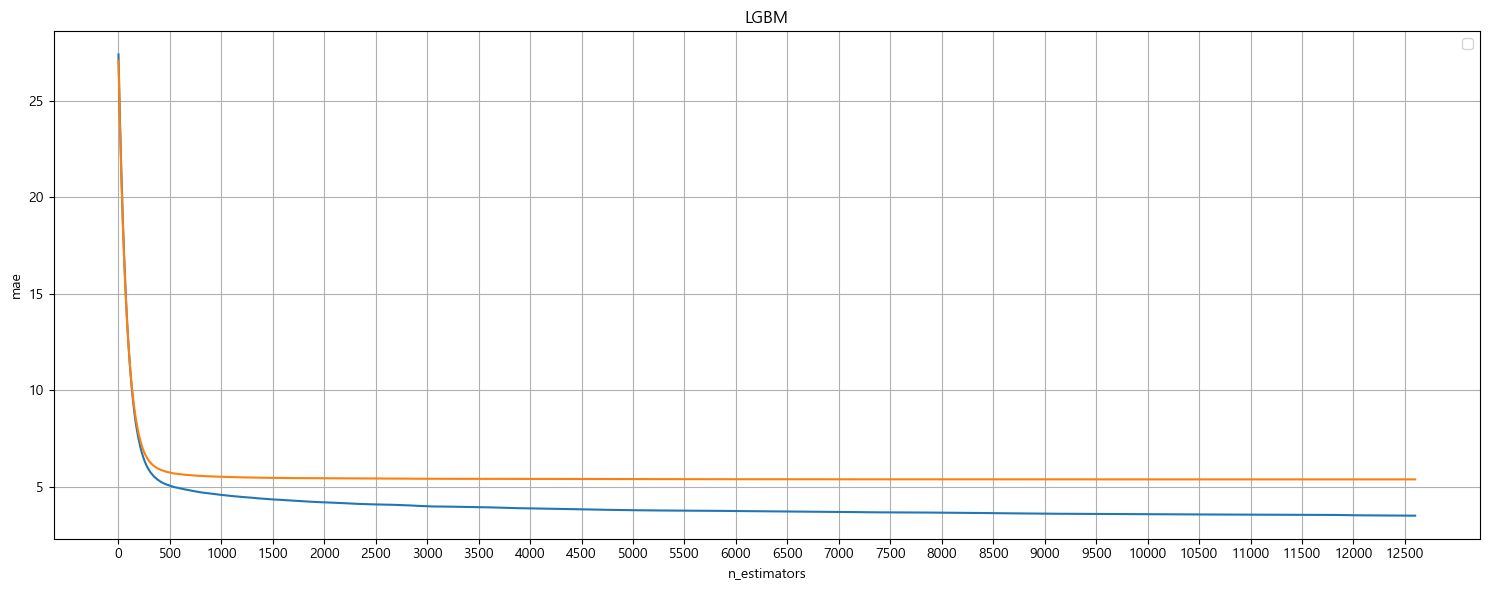

In [47]:
plt.figure(figsize=(15,6))
plt.plot(LGBM.evals_result_['training']['l1'])
plt.plot(LGBM.evals_result_['valid_1']['l1'])
plt.xticks(np.arange(0,12601,step=500))
plt.xlabel('n_estimators')
plt.ylabel('mae')
plt.title('LGBM')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

- XGB

In [37]:
XGB = xgb(objective='reg:absoluteerror', eval_metric='mae', n_estimators=90000, random_state=42,
          max_depth=10, learning_rate=.01, gamma=.6, subsample=.8, reg_alpha=1, reg_lambda=.05,
          colsample_bytree=.5, min_child_weight=10, base_score=100)
XGB.fit(x_train, y_train, eval_set=[(x_train, y_train),(x_val, y_val)], early_stopping_rounds=1000, verbose=1000)

[0]	validation_0-mae:53.89940	validation_1-mae:54.08791
[1000]	validation_0-mae:45.60124	validation_1-mae:45.84586
[2000]	validation_0-mae:37.71427	validation_1-mae:38.02406
[3000]	validation_0-mae:30.36389	validation_1-mae:30.75856
[4000]	validation_0-mae:23.63246	validation_1-mae:24.09921
[5000]	validation_0-mae:17.58543	validation_1-mae:18.12551
[6000]	validation_0-mae:12.46411	validation_1-mae:13.08565
[7000]	validation_0-mae:8.51884	validation_1-mae:9.23774
[8000]	validation_0-mae:6.01954	validation_1-mae:6.87256
[9000]	validation_0-mae:4.85550	validation_1-mae:5.84441
[10000]	validation_0-mae:4.46646	validation_1-mae:5.56781
[11000]	validation_0-mae:4.33969	validation_1-mae:5.51198
[12000]	validation_0-mae:4.24473	validation_1-mae:5.48076
[13000]	validation_0-mae:4.16395	validation_1-mae:5.45791
[14000]	validation_0-mae:4.09088	validation_1-mae:5.44254
[15000]	validation_0-mae:4.02978	validation_1-mae:5.42996
[16000]	validation_0-mae:3.97825	validation_1-mae:5.41960
[17000]	valid

XGBRegressor(base_score=100, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='mae', feature_types=None,
             gamma=0.6, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=10, missing=nan, monotone_constraints=None,
             n_estimators=90000, n_jobs=None, num_parallel_tree=None,
             objective='reg:absoluteerror', predictor=None, ...)

In [31]:
print("XGB Validation MAE : {}".format(mae(y_val, XGB.predict(x_val))))

XGB Validation MAE : 5.359566075955884


5.360705163687093

In [ ]:
params = ['Lossguide']
result_dict = {}
for par in tqdm(params):
    CAT = cat(loss_function='MAE', eval_metric='MAE', iterations=50000, random_state=42,
              max_depth=6, grow_policy=par)
    CAT.fit(x_train, y_train, eval_set=(x_val, y_val), use_best_model=True, early_stopping_rounds=1000, verbose=False)
    result_dict[par] = mae(y_val, CAT.predict(x_val))

In [44]:
CAT = cat(loss_function='MAE', eval_metric='MAE', iterations=50000, random_state=42,
              max_depth=6, grow_policy='Depthwise')
CAT.fit(x_train, y_train, eval_set=(x_val, y_val), use_best_model=True, early_stopping_rounds=1000, verbose=100)

0:	learn: 26.9395235	test: 26.6116378	best: 26.6116378 (0)	total: 29.7ms	remaining: 24m 44s
100:	learn: 7.6724545	test: 7.7247948	best: 7.7247948 (100)	total: 2.95s	remaining: 24m 17s
200:	learn: 6.5675420	test: 6.6871791	best: 6.6871791 (200)	total: 5.69s	remaining: 23m 29s
300:	learn: 6.1629074	test: 6.3285826	best: 6.3285826 (300)	total: 8.32s	remaining: 22m 53s
400:	learn: 5.8818335	test: 6.0976144	best: 6.0976144 (400)	total: 11s	remaining: 22m 41s
500:	learn: 5.6549672	test: 5.9321584	best: 5.9321584 (500)	total: 13.8s	remaining: 22m 38s
600:	learn: 5.4964347	test: 5.8277863	best: 5.8277863 (600)	total: 16.5s	remaining: 22m 38s
700:	learn: 5.3737094	test: 5.7470527	best: 5.7470527 (700)	total: 19.2s	remaining: 22m 33s
800:	learn: 5.2857980	test: 5.6979746	best: 5.6979746 (800)	total: 21.8s	remaining: 22m 20s
900:	learn: 5.2127484	test: 5.6615138	best: 5.6615138 (900)	total: 24.5s	remaining: 22m 12s
1000:	learn: 5.1446576	test: 5.6270077	best: 5.6270077 (1000)	total: 27.1s	remaini

KeyboardInterrupt: 

In [38]:
CAT.best_iteration_

2413

In [31]:
result_dict

{6: 5.360705163687093, 8: 5.363185202726911, 10: 5.407398728500752}

In [ ]:
"""
param = {
        "border_count":trial.suggest_categorical('border_count', [None, 254]),

        leaf_estimated_method : Exact, Gradient
        grow_policy : SymmetricTree, Depthwise, Lossguide
        bagging_temperature : 1, 0~ **more aggressive higher value**
        max_bin : auto, 1~65535
        boosting_type : Auto, Ordered, Plain
        min_data_in_leaf : 1~, **Lossguide, Depthwise only**
        sampling_frequency : PerTreeLevel, PerTree
        max_leaves : 31, 2~64 **Lossguide only**
        rsm : 1.0, 0.0~1.0
        l2_leaf_reg : 3, int
        learning_rate : .009, 0~1 **자동 설정**
        bootstrap_type : Bayesian, Bernoulli, MVS, Poisson(GPU only), No**objective, task_type, bagging_temperature, sampling_unit에 의해 자동**
        subsample : Poisson, Bernoulli .66, MVS .8, float
        sampling_unit : Object, Group
        random_strength : 1, float
}
"""

In [32]:
submission['가격'] = XGB.predict(test_x_scaled)
submission.to_csv('./XGB_file.csv', index=False)

<Axes: >

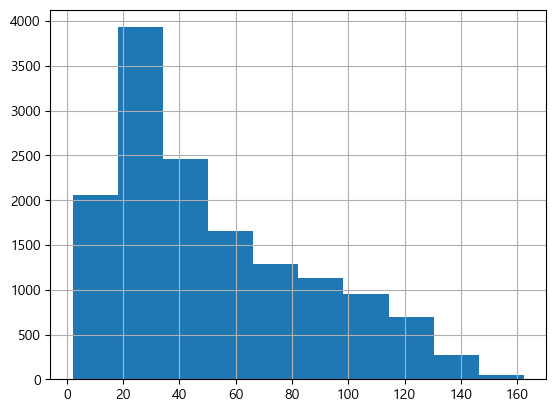

In [29]:
pd.read_csv('lgbm_tune.csv')['가격'].hist()

<Axes: >

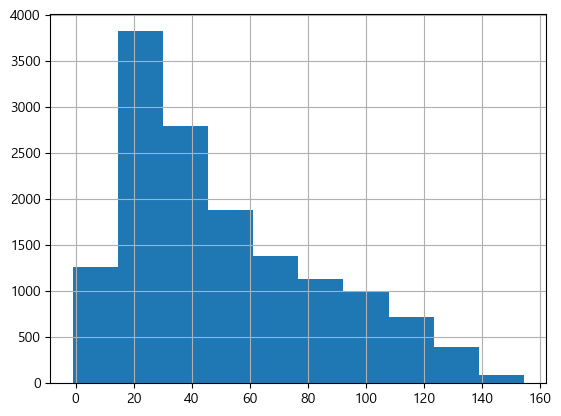

In [33]:
submission['가격'].hist()

<Axes: >

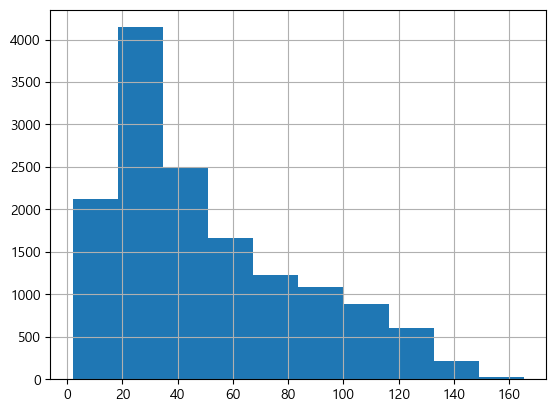

In [28]:
submission['가격'].hist()